In [2]:
library(tidyverse)
library(lubridate)

# Read in incidents dataset
incidents <- read_csv('downsample_police-department-incidents.csv')

# Read in calls dataset
calls <- read_csv('downsample_police-department-calls-for-service.csv')

print('Done!')

Parsed with column specification:
cols(
  IncidntNum = col_double(),
  Category = col_character(),
  Descript = col_character(),
  DayOfWeek = col_character(),
  Date = col_datetime(format = ""),
  Time = col_time(format = ""),
  PdDistrict = col_character(),
  Resolution = col_character(),
  Address = col_character(),
  X = col_double(),
  Y = col_double(),
  Location = col_character(),
  PdId = col_double()
)
Parsed with column specification:
cols(
  `Crime Id` = col_double(),
  Descript = col_character(),
  `Report Date` = col_datetime(format = ""),
  Date = col_datetime(format = ""),
  `Offense Date` = col_datetime(format = ""),
  `Call Time` = col_time(format = ""),
  `Call Date Time` = col_datetime(format = ""),
  Disposition = col_character(),
  Address = col_character(),
  City = col_character(),
  State = col_character(),
  `Agency Id` = col_double(),
  `Address Type` = col_character(),
  `Common Location` = col_character()
)


[1] "Done!"


In [3]:
# Glimpse the structure of both datasets
glimpse(incidents)
glimpse(calls)

# Aggregate the number of reported incidents by Date
daily_incidents <- incidents %>%
    count(Date, sort = TRUE) %>%
    rename(n_incidents = n)

# Aggregate the number of calls for police service by Date
daily_calls <- calls %>%
    count(Date, sort = TRUE) %>%
    rename(n_calls = n)

Observations: 84,000
Variables: 13
$ IncidntNum <dbl> 176122807, 160569314, 160362475, 160435298, 90543656, 18...
$ Category   <chr> "LARCENY/THEFT", "ASSAULT", "ROBBERY", "KIDNAPPING", "MI...
$ Descript   <chr> "GRAND THEFT FROM UNLOCKED AUTO", "BATTERY", "ROBBERY, B...
$ DayOfWeek  <chr> "Saturday", "Thursday", "Tuesday", "Friday", "Tuesday", ...
$ Date       <dttm> 2017-05-13, 2016-07-14, 2016-05-03, 2016-05-27, 2009-05...
$ Time       <time> 10:20:00, 16:00:00, 14:19:00, 23:57:00, 07:40:00, 18:00...
$ PdDistrict <chr> "SOUTHERN", "MISSION", "NORTHERN", "SOUTHERN", "TARAVAL"...
$ Resolution <chr> "NONE", "NONE", "ARREST, BOOKED", "ARREST, BOOKED", "LOC...
$ Address    <chr> "800 Block of BRYANT ST", "MISSION ST / CESAR CHAVEZ ST"...
$ X          <dbl> -122.4034, -122.4182, -122.4299, -122.4050, -122.4612, -...
$ Y          <dbl> 37.77542, 37.74817, 37.77744, 37.78512, 37.71912, 37.806...
$ Location   <chr> "{'latitude': '37.775420706711', 'human_address': '{\"ad...
$ PdId       <dbl

In [4]:

# Join data frames to create a new "mutated" set of information
shared_dates <- inner_join(daily_incidents, daily_calls, by = "Date")

# Take a glimpse of this new data frame
glimpse(shared_dates)

print('Done!')

Observations: 776
Variables: 3
$ Date        <dttm> 2017-03-01, 2017-09-01, 2016-04-01, 2017-03-17, 2016-1...
$ n_incidents <int> 124, 124, 120, 118, 117, 114, 111, 110, 110, 110, 109, ...
$ n_calls     <int> 133, 138, 124, 129, 115, 120, 127, 106, 124, 108, 111, ...
[1] "Done!"


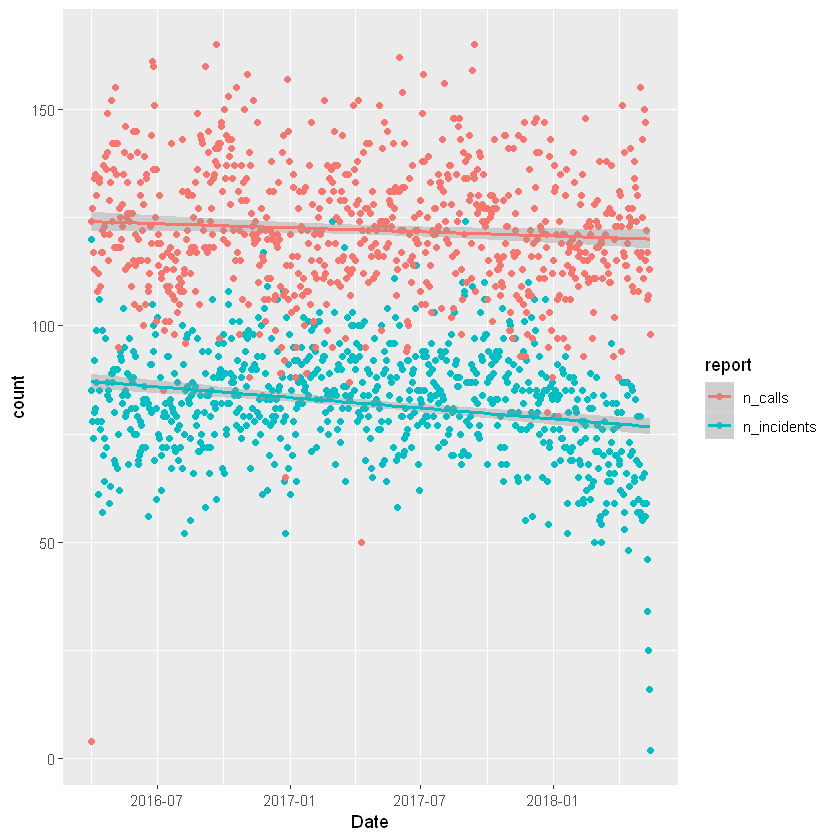

In [5]:
# Gather into long format using the "Date" column to define observations
plot_shared_dates <- shared_dates %>%
  gather(key = report, value = count, -Date)

# Plot points and regression trend lines
ggplot(plot_shared_dates, aes(x = Date, y = count, color = report)) +
  geom_point() +
  geom_smooth(method = "lm", formula = y ~ x)


In [6]:
# Calculate correlation coefficient between daily frequencies
daily_cor <- cor(shared_dates$n_incidents, shared_dates$n_calls)
print(daily_cor)

# Summarize frequencies by month
correlation_df <- shared_dates %>% 
  mutate(month = month(Date)) %>%
  group_by(month) %>% 
  summarize(n_incidents = sum(n_incidents),
            n_calls = sum(n_calls))

# Calculate correlation coefficient between monthly frequencies
monthly_cor <- cor(correlation_df$n_incidents, correlation_df$n_calls)
print(monthly_cor)


[1] 0.1469688
[1] 0.970683


In [7]:
# Subset calls to police by shared_dates
calls_shared_dates <- calls %>%
  semi_join(shared_dates, by = "Date")

# Perform a sanity check that we are using this filtering join function appropriately
print(identical(sort(unique(shared_dates$Date)), sort(unique(calls_shared_dates$Date))))

# Filter recorded incidents by shared_dates
incidents_shared_dates <- incidents %>%
  semi_join(shared_dates, by = "Date")


[1] TRUE


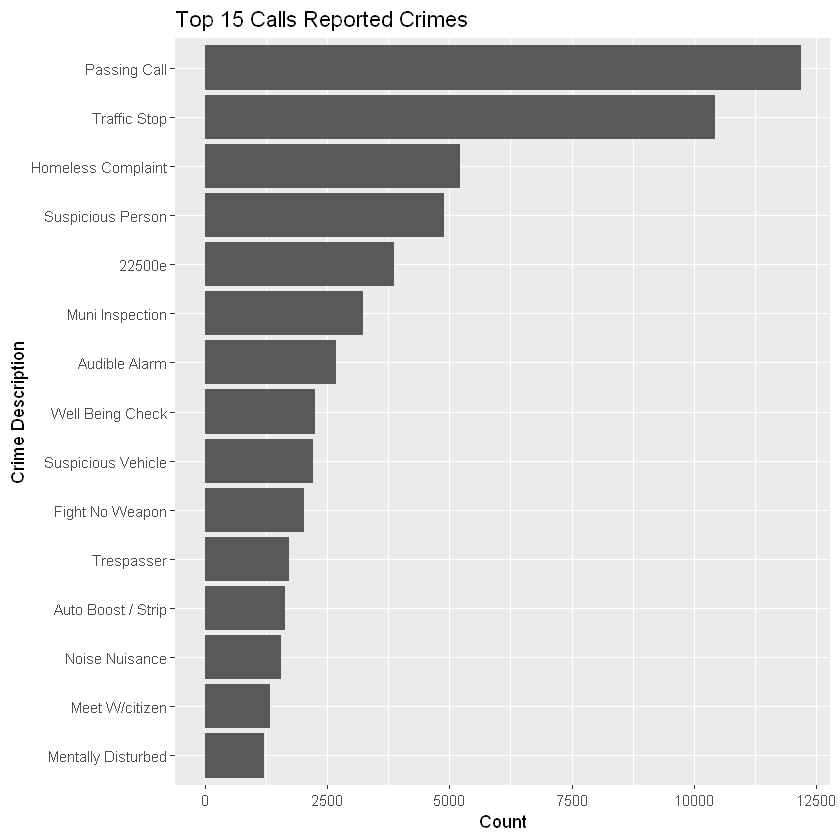

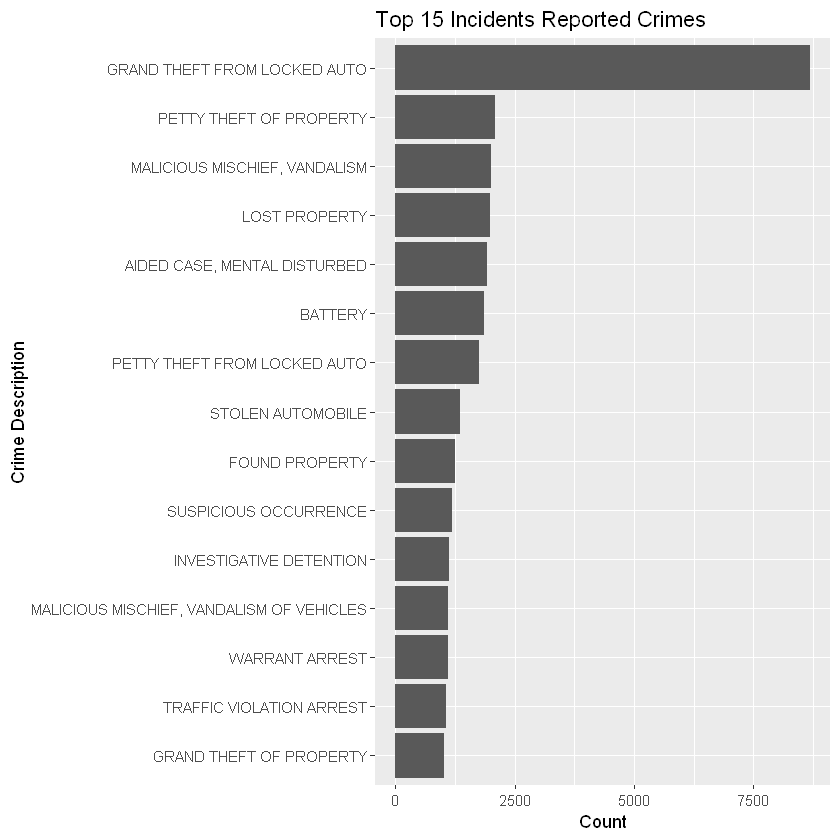

In [8]:
# Create a bar chart of the number of calls for each crime
plot_calls_freq <- calls_shared_dates %>% 
  count(Descript) %>% 
  top_n(15, n) %>% 
  ggplot(aes(x = reorder(Descript, n), y = n)) +
  geom_bar(stat = 'identity') +
  ylab("Count") +
  xlab("Crime Description") +
  ggtitle("Top 15 Calls Reported Crimes") +
  coord_flip()

# Create a bar chart of the number of reported incidents for each crime
plot_incidents_freq <- incidents_shared_dates %>% 
  count(Descript) %>% 
  top_n(15, n) %>% 
  ggplot(aes(x = reorder(Descript, n), y = n)) +
  geom_bar(stat = 'identity') +
  ylab("Count") +
  xlab("Crime Description") +
  ggtitle("Top 15 Incidents Reported Crimes") +
  coord_flip()

# Output the plots
print(plot_calls_freq)
print(plot_incidents_freq)


In [9]:
# Arrange the top 10 locations of called in crimes in a new variable
location_calls <- calls_shared_dates %>%
  filter(Descript == "Auto Boost / Strip") %>% 
  count(Address) %>% 
  arrange(desc(n))%>% 
  top_n(10, n)

# Arrange the top 10 locations of reported incidents in a new variable
location_incidents <- incidents_shared_dates %>%
  filter(Descript == "GRAND THEFT FROM LOCKED AUTO") %>% 
  count(Address) %>% 
  arrange(desc(n))%>% 
  top_n(10, n)

# Output the top locations of each dataset for comparison
location_calls
location_incidents


Address,n
1100 Block Of Point Lobos Av,21
3600 Block Of Lyon St,20
100 Block Of Christmas Tree Point Rd,18
1300 Block Of Webster St,12
500 Block Of 6th Av,12
800 Block Of Vallejo St,10
1000 Block Of Great Hy,9
100 Block Of Hagiwara Tea Garden Dr,7
1100 Block Of Fillmore St,7
3300 Block Of 20th Av,7


Address,n
800 Block of BRYANT ST,441
500 Block of JOHNFKENNEDY DR,89
1000 Block of POINTLOBOS AV,84
800 Block of MISSION ST,61
2600 Block of GEARY BL,38
3600 Block of LYON ST,36
1300 Block of WEBSTER ST,35
1100 Block of FILLMORE ST,34
22ND ST / ILLINOIS ST,33
400 Block of 6TH AV,30


In [12]:
# Read in a static map of San Francisco 
.... <- readRDS("sf_map.RDS")

# Filter grand theft auto incidents
auto_incidents <- .... %>% 
    ....(.... == "GRAND THEFT FROM LOCKED AUTO")

# Overlay a density plot of auto incidents on the map
ggmap(....) +
  stat_density_2d(
    aes(x = X, y = Y, fill = ..level..), alpha = 0.15,
    size = 0.01, bins = 30, data = ....,
    geom = "polygon")

ERROR: Error in readRDS("sf_map.RDS"): unknown input format
